# Will They Purchase Your Products?

## Introduction

This project is made for a new startup company that has just launched a new online shopping website. The marketing team has asked for a review of the dataset of online shoppers' purchasing intentions gathered over the last year. Specifically, the team wants to generate some insights into customer browsing behaviors in November and December, the busiest months for shoppers. The first decision was to identify two groups of customers: those with a low purchase rate and returning customers. After identifying these groups, it should be determined the probability that any of these customers will make a purchase in a new marketing campaign to help gauge potential success for next year's sales. Additionally, they are interested in the number of product-related pages visited, whether the customer makes a purchase or not.

In summary, we are going to answer the next questions:

1. What are the purchase rates for online shopping sessions by customer type for November and December?
2. A new campaign for the returning customers will boost their purchase rate by 15%. What's the likelihood of achieving at least 110 sales out of 500 online shopping sessions for the returning customers?
3. How many product-related pages does a customer visit in a session on average when making a purchase? Does this mean changes on the sessions with no purchases made?

### Data description:

The `online_shopping_session_data.csv` file contains several columns about each shopping session. Each shopping session corresponded to a single user. 

|Column|Description|
|--------|-----------|
|`SessionID`|unique session ID|
|`Administrative`|number of pages visited related to the customer account|
|`Administrative_Duration`|total amount of time spent (in seconds) on administrative pages|
|`Informational`|number of pages visited related to the website and the company|
|`Informational_Duration`|total amount of time spent (in seconds) on informational pages|
|`ProductRelated`|number of pages visited related to available products|
|`ProductRelated_Duration`|total amount of time spent (in seconds) on product-related pages|
|`BounceRates`|average bounce rate of pages visited by the customer|
|`ExitRates`|average exit rate of pages visited by the customer|
|`PageValues`|average page value of pages visited by the customer|
|`SpecialDay`|closeness of the site visiting time to a specific special day|
|`Weekend`|indicator whether the session is on a weekend|
|`Month`|month of the session date|
|`CustomerType`|customer type|
|`Purchase`|class label whether the customer make a purchase|

## Analysis & Findings

To start, let's import all the necessary tools and take a look at the given data.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import seaborn as sns
# Custom theme for visuals
plt.style.use("mytheme.mplstyle")
# Custom color scheme for visual elements
from my_colors import my_colors

# Load and view the data
shopping_data = pd.read_csv("online_shopping_session_data.csv")
shopping_data.head()

,SessionID,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Month,CustomerType,Purchase
0,1,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,False,Feb,Returning_Customer,0.0
1,2,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,False,Feb,Returning_Customer,0.0
2,3,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,False,Feb,Returning_Customer,0.0
3,4,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,False,Feb,Returning_Customer,0.0
4,5,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,True,Feb,Returning_Customer,0.0


It's important to note that this data is already cleaned. So, the next step is to take a look at the customer's purchase behavior in November and December.

### Purchase ratios

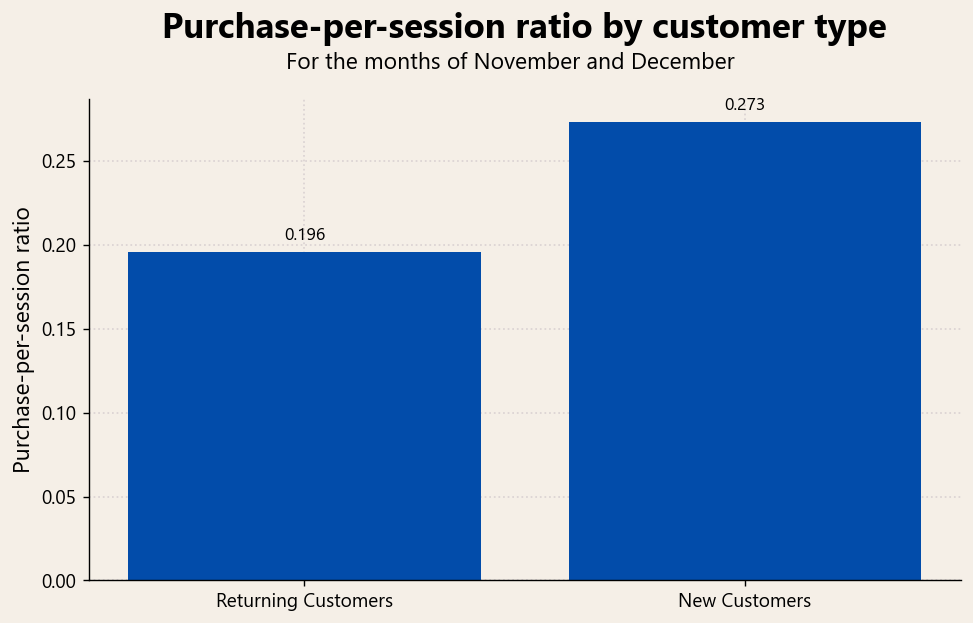

In [2]:
# Extracting the needed data
purchase_rates = {}
shopping_data_nov_dec = shopping_data[shopping_data['Month'].isin(['Nov', 'Dec'])]
returning_customers = shopping_data_nov_dec[shopping_data_nov_dec['CustomerType'] == 'Returning_Customer']
purchase_rates['Returning Customers'] = returning_customers['Purchase'].sum() / len(returning_customers)
new_customers = shopping_data_nov_dec[shopping_data_nov_dec['CustomerType'] == 'New_Customer']
purchase_rates['New Customers'] = new_customers['Purchase'].sum() / len(new_customers)

# Plotting the results
plt.bar(x=purchase_rates.keys(), height=purchase_rates.values())
for i, value in enumerate(purchase_rates.values()):
    plt.text( i, value+ 0.005, f'{round(value,3)}', ha='center', va='bottom', fontsize=10)
plt.title('Purchase-per-session ratio by customer type', pad=35)
plt.suptitle('For the months of November and December', y = 0.955)
plt.ylabel('Purchase-per-session ratio')
plt.show()

The plot shows that 19.6% of the returning customer's sessions are converted into sales for the specified months. This ratio is bigger for the new customers, being 27.3%.

### Purchase likelihood

The best approach to create a new sales estimation is using a binomial distribution *B(n,p)*. In this case *n* will be the next 500 sessions on the company website and *p* the purchases-per-session ratio of the returning customers, which increased by 15%. This will give us an additional insight into the possible reaction of the customers to this campaign.

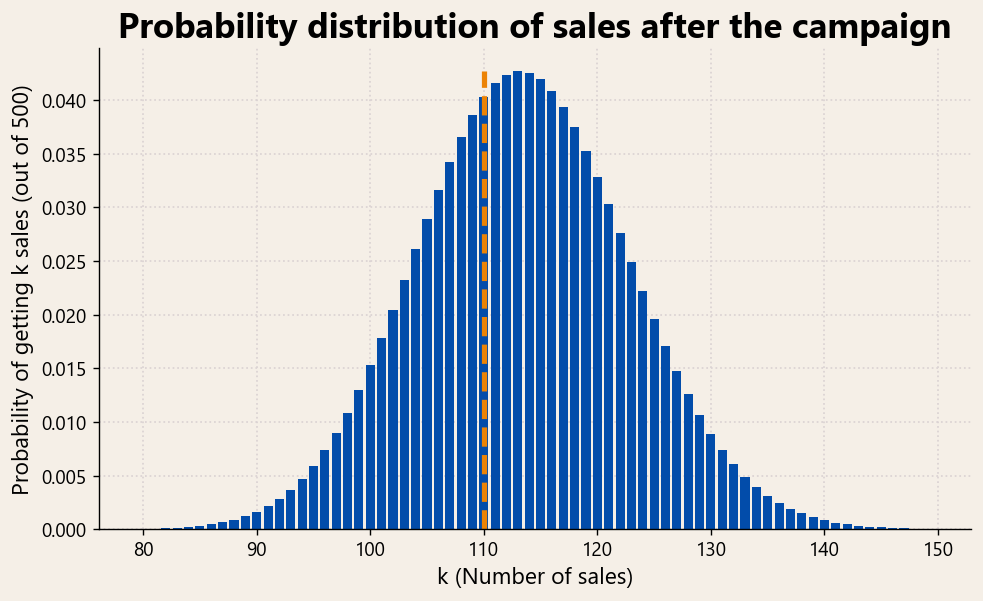

In [3]:
# Creating the distribution
probabilities = []
for k in range(501):
    k_purchases_probability = binom.pmf(k,500,purchase_rates['Returning Customers'] * 1.15)
    probabilities.append(k_purchases_probability)
# Plotting the results
plt.bar(x=range(80,150), height=probabilities[79:149])
plt.vlines(x=110,ymin=0, ymax=max(probabilities),color=my_colors['orange'], linestyles='dashed')
plt.title('Probability distribution of sales after the campaign')
plt.xlabel('k (Number of sales)')
plt.ylabel('Probability of getting k sales (out of 500)')
plt.show()

The visual suggests that the value we are looking for is slightly greater than 50% and also tells us that the most expected sales volumes are between 105 and 120. With this, it will be easier to tell if the next number to calculate is consistent with the visual intuition.

In [4]:
# Calculation of probability
prob_at_least_110_sales = 1 - binom.cdf(109,500,purchase_rates['Returning Customers'] * 1.15)
prob_at_least_110_sales

np.float64(0.6212673344263308)

The chances of getting at least 110 purchases in the next 500 returning customers' sessions is 62.1%, which makes sense since more than half of the area in the chart is to the right of the line represented by this quantity. It also shows the high likelihood of success for the campaign.

### Average Pages per Session

To get the data of each kind of session (with or without purchases), we can use a similar workflow to the one used to segment the customer types.

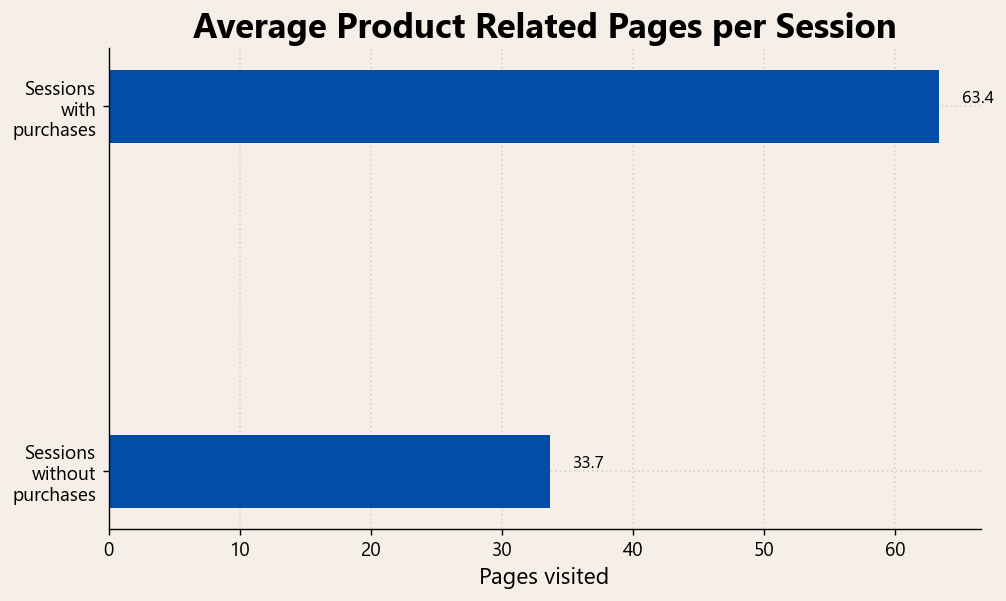

In [5]:
# Getting the means
no_purchases = shopping_data_nov_dec[shopping_data_nov_dec['Purchase'] == 0]
purchases = shopping_data_nov_dec[shopping_data_nov_dec['Purchase'] == 1]
no_purchases_mean = no_purchases['ProductRelated'].mean()
purchases_mean = purchases['ProductRelated'].mean()
# Creating the chart
y = np.arange(0,2)
height = 0.2
plt.barh(y, [no_purchases_mean, purchases_mean], height=height)
for i, value in enumerate([no_purchases_mean, purchases_mean]):
    plt.text( value + 3, i, f'{round(value,1)}', ha='center', va='bottom', fontsize=10)
plt.yticks(y, ['Sessions\nwithout\npurchases', 'Sessions\nwith\npurchases'])
plt.title('Average Product Related Pages per Session')
plt.xlabel('Pages visited')
plt.show()

In [6]:
#Calculating the ratio
pages_ratio = purchases_mean / no_purchases_mean
pages_ratio

np.float64(1.8820613835099045)

We have found that, in the sessions with purchases, the customers visit on average 63.4 product-related pages. This is 95% more than the sessions with no purchases made.

## Conclusion

To summarize the project, here we have the answers to the three questions initially asked:

1. The new customers have a purchase-per-session ratio of 27.3%, which is greater than the one for the returning customers, being this of only 19.6%.
2. The campaign for returning customers is highly likely to succeed since there's a probability of 62.1% of achieving or exceeding its goal.
3. An average customer visits 63.4 product-related pages when making a purchase, 95% more than the sessions that ended without purchases.